## Clustering Demographics 

In [5]:
######################## LOAD IN FILES #############################
import os
import pandas as pd
import sys
import importlib
import numpy as np
import pandas as pd
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import math
import plotly.express as px

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import clustering as cl
from scripts import feature_selection as fs
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(cl)
importlib.reload(fs)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, demographic_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols, daily_v2_weather
from scripts.variables import df_names, df_mis, df_names_with_mis
demo_df = pd.read_csv(os.path.join(brighten_dir, f'demographics.csv'))
demographic_vars = [col for col in demo_df.columns if col!='num_id']
id_columns.append('idx')

### Calculate the RMSSD for each participant on each variable
The root mean square of successive differences between (RMSSD) is obtained by first calculating each successive time difference (or value difference) between observations. Then, each of the values is squared and the result is averaged before the square root of the total is obtained. 

The RMSSD is used as a 'stability' metric for that item for that participant.

In [39]:
demo_df = pd.read_csv(os.path.join(brighten_dir, 'demographics.csv'))

for name in df_names:
    if 'day' in name:
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
        means = {}
        diffs = {}
        for sub in df['num_id'].unique():
            diffs[sub] = {}
            means[sub] = {}
            sub_df = df.query('num_id == @sub').reset_index(drop=True)
            for col in sub_df.columns:
                if col not in id_columns and 'Unnamed' not in col and '_indicator' not in col and "missing" not in col and col not in demo_df.columns:
                    diffs[sub][col] = []
                    # Save mean values for each sub/col
                    means[sub][col] = sub_df[col].mean()
                    for i in range(len(sub_df)):
                        if i == 0:
                            continue
                        else:
                            diff = sub_df.loc[i, col] - sub_df.loc[i-1, col]
                            diffsq = diff*diff
                            diffs[sub][col].append(diffsq)

        # Create & save RMSSD values for each sub/col
        rmssd = {}
        for sub in diffs.keys():
            rmssd[sub] = {}
            for col in diffs[sub]:
                avg = sum(diffs[sub][col]) / len(diffs[sub][col])
                sqrt = math.sqrt(avg) 
                rmssd[sub][col] = round(sqrt, 3)

        # Create RMSSD long dataframe for plotting
        rmssd_df = pd.DataFrame(rmssd)
        rmssd = rmssd_df.reset_index()
        rmssd_long = rmssd.melt(id_vars='index', var_name='subject', value_name='value')
        # Plot RMSSD values
        rmssd_fig = px.scatter(rmssd_long, x='index', y='value', color='index', height=500, width=700, title=f'RMSSD for each subject in {name}')
        rmssd_fig.show()
        
        # Create means long dataframe for plotting
        means_df = pd.DataFrame(means)
        means = means_df.reset_index()
        means_long = means.melt(id_vars='index', var_name='subject', value_name='value')
        # Plot mean values
        means_fig = px.scatter(means_long, x='index', y='value', color='index', height=500, width=700, title=f'Means for each subject in {name}')
        means_fig.show()


## plot rmssd 



DATAFRAME: v1_day
In df there are 522 subjects.


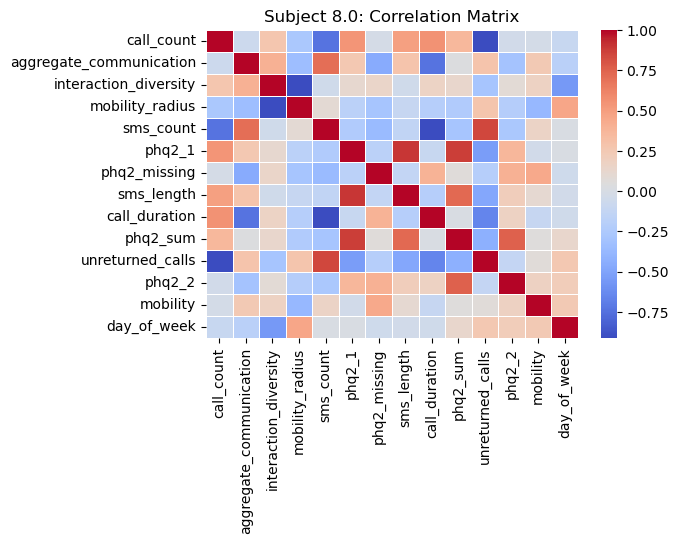

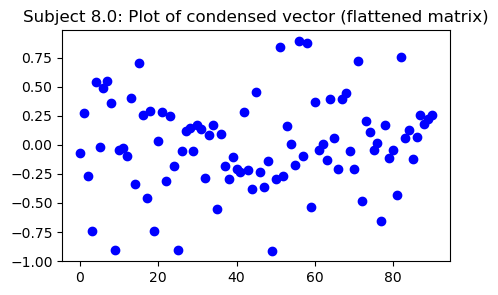

522  subs with symptom matrices
522  filled condensed arrays
In df there are 522 subjects.


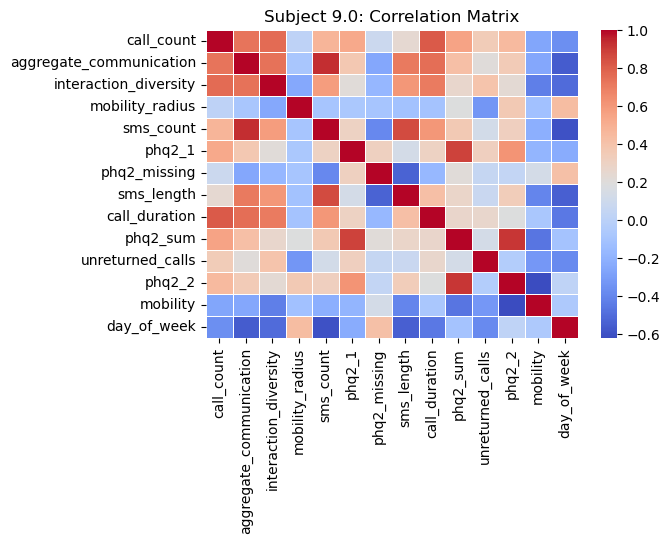

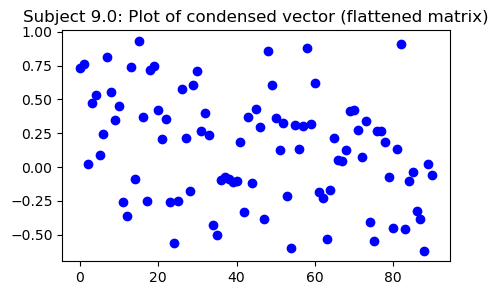

443 First half subs with symptom matrices
443 First half filled condensed arrays
In df there are 522 subjects.


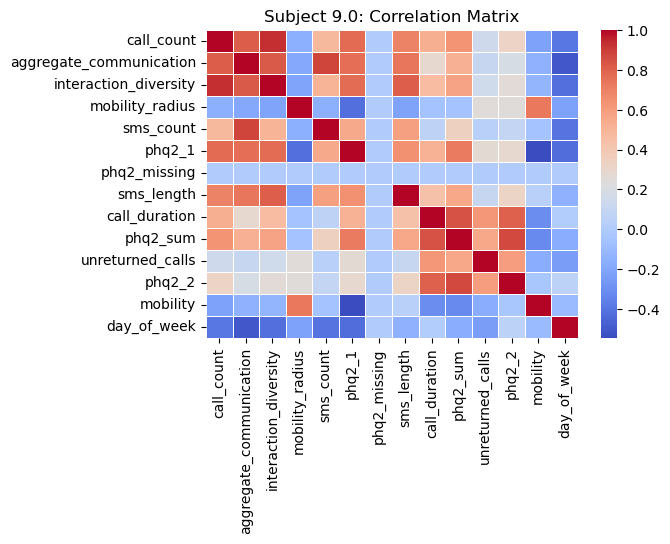

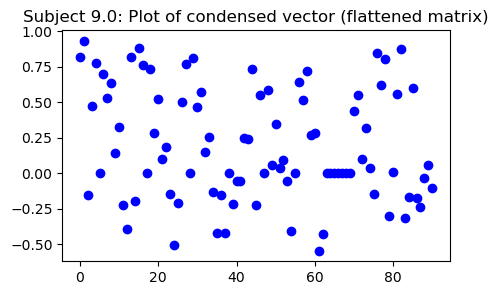

443 Second half subs with symptom matrices
443 Second half filled condensed arrays


DATAFRAME: v2_day
In df there are 287 subjects.


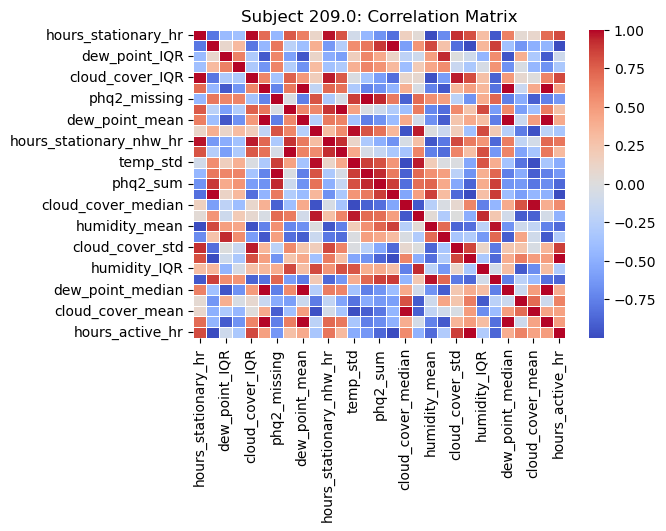

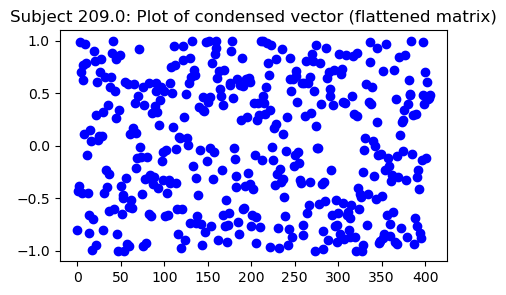

287  subs with symptom matrices
287  filled condensed arrays
In df there are 287 subjects.


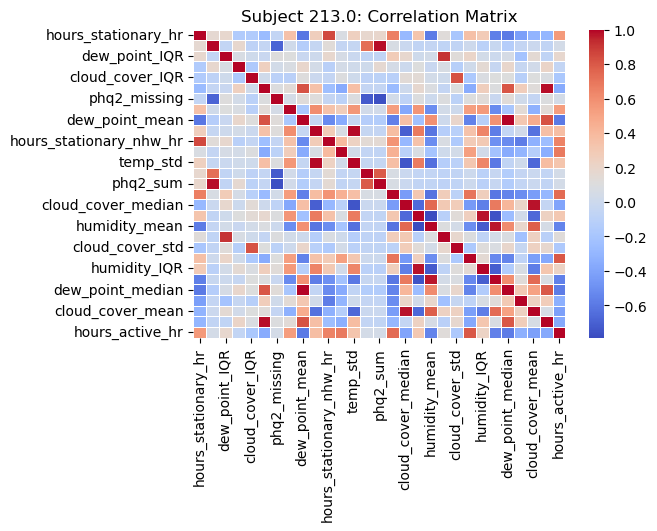

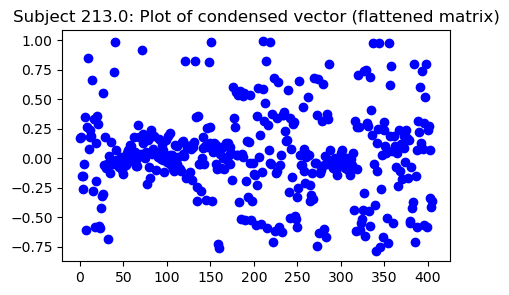

198 First half subs with symptom matrices
198 First half filled condensed arrays
In df there are 287 subjects.


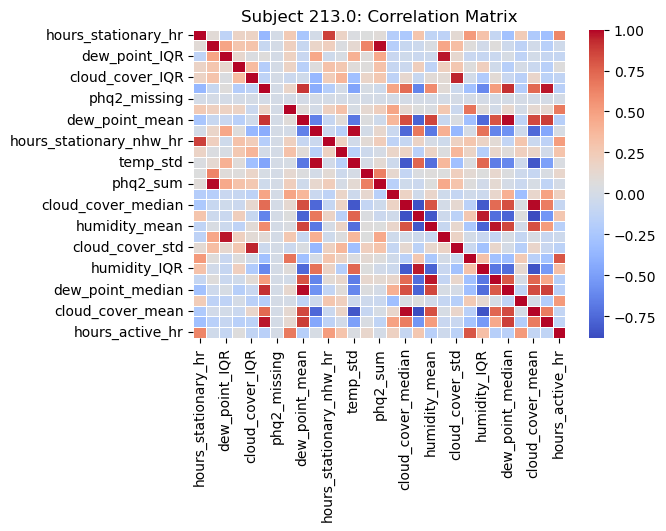

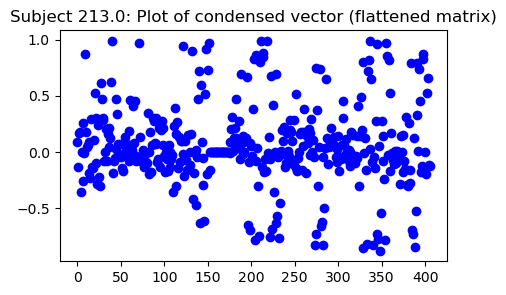

198 Second half subs with symptom matrices
198 Second half filled condensed arrays


In [10]:
#### Take the average of each subject's symptom correlation 
# and use it to make clusters of variables
importlib.reload(fs)
symptom_matrices_dict = {}
flattened_matrices_dict = {}
target_cols = phq2_cols+phq9_cols

# Create dicts of all subjects' correlation matrices
for name in df_names:
    if 'day' in name:
        symptom_matrices_dict[name] = {}
        flattened_matrices_dict[name] = {}
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df = df.loc[:, ~df.columns.str.contains('_int')]
        print(f'\n\nDATAFRAME: {name}')
        ignore_cols = [col for col in df.columns if col in demographic_vars+id_columns or "_indicator" in col or "_bin" in col]
        symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1)
        half1_symptom_matrix_dict, half1_flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1, first_half=True)
        half2_symptom_matrix_dict, half2_flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1, second_half=True)
        symptom_matrices_dict[name]['full'] = symptom_matrix_dict
        symptom_matrices_dict[name]['half1'] = half1_symptom_matrix_dict
        symptom_matrices_dict[name]['half2'] = half2_symptom_matrix_dict
        flattened_matrices_dict[name]['full'] = flattened_matrix_dict
        flattened_matrices_dict[name]['half1'] = half1_flattened_matrix_dict
        flattened_matrices_dict[name]['half2'] = half2_flattened_matrix_dict




In [ ]:
for name, df_dict in flattened_matrices_dict.items():
    for sub, corr_vector in df_dict['half1'].items():
        


In [ ]:
############### Plot individual networks of symptom matrices #################

for name, df_dict in symptom_matrices_dict.items():
    count=0
    for sub, corr_matrix in df_dict['full'].items():
        if count<1:
            fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
            count=+1

In [ ]:
## Plot options
for name, df in symptom_matrices_dict.items():
    avg_matrix = fs.average_matrix(df['full'])
    fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward
